In [21]:
# =========================================================
# UNIT 3 – Data Processing with Spark
# Activity 2: RDD/DataFrame Transformation Benchmarking
# Dataset: Wine Quality (Red Wine)
# =========================================================

In [22]:
# ---------------------------------------------------------
# 0. Import Libraries
# ---------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, split, regexp_replace
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd


In [23]:
# ---------------------------------------------------------
# 1. Initialize Spark Session
# ---------------------------------------------------------
spark = SparkSession.builder \
    .appName("WineQualityClassification") \
    .getOrCreate()


In [24]:
# ---------------------------------------------------------
# 2. Load CSV
# ---------------------------------------------------------
# Dataset is incorrectly ingested as a single column
wine_df = spark.read.csv("/content/winequality-red.csv", header=True)

In [25]:
# Rename single column
wine_raw = wine_df.withColumnRenamed(wine_df.columns[0], "raw_row")

In [26]:
# Split into proper columns
split_cols = split(col("raw_row"), ",")

wine_fixed = wine_raw.select(
    split_cols[0].alias("fixed_acidity"),
    split_cols[1].alias("volatile_acidity"),
    split_cols[2].alias("citric_acid"),
    split_cols[3].alias("residual_sugar"),
    split_cols[4].alias("chlorides"),
    split_cols[5].alias("free_sulfur_dioxide"),
    split_cols[6].alias("total_sulfur_dioxide"),
    split_cols[7].alias("density"),
    split_cols[8].alias("pH"),
    split_cols[9].alias("sulphates"),
    split_cols[10].alias("alcohol"),
    split_cols[11].alias("quality")
)

In [27]:
# Remove quotes and cast numeric types
for c in wine_fixed.columns:
    wine_fixed = wine_fixed.withColumn(
        c,
        regexp_replace(col(c), '"', '').cast("double")
    )

wine_fixed = wine_fixed.withColumn("quality", col("quality").cast("int"))


In [28]:
# ---------------------------------------------------------
# 3. Data Preparation
# ---------------------------------------------------------
# Create quality label
wine_clean = wine_fixed.withColumn(
    "quality_label",
    when(col("quality") >= 7, "High")
    .when(col("quality") >= 5, "Medium")
    .otherwise("Low")
)

wine_clean.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|       Medium|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|       Medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|       Medium|
|         11.2| 

In [29]:
# Encode labels
indexer = StringIndexer(inputCol="quality_label", outputCol="label")
wine_clean = indexer.fit(wine_clean).transform(wine_clean)


In [30]:
# ---------------------------------------------------------
# 4. Feature Vector
# ---------------------------------------------------------
feature_cols = [
    "fixed_acidity", "volatile_acidity", "citric_acid",
    "residual_sugar", "chlorides", "free_sulfur_dioxide",
    "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
wine_clean = assembler.transform(wine_clean)


In [31]:
# ---------------------------------------------------------
# 5. Train-Test Split
# ---------------------------------------------------------
train_df, test_df = wine_clean.randomSplit([0.8, 0.2], seed=42)


In [32]:
# ---------------------------------------------------------
# 6. Model Training
# ---------------------------------------------------------
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
model = rf.fit(train_df)

In [33]:
# ---------------------------------------------------------
# 7. Model Prediction
# ---------------------------------------------------------
predictions = model.transform(test_df)
predictions.select("features", "label", "prediction").show(5)


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[4.9,0.42,0.0,2.1...|  1.0|       1.0|
|[5.0,0.74,0.0,1.2...|  0.0|       0.0|
|[5.0,1.04,0.24,1....|  0.0|       0.0|
|[5.2,0.32,0.25,1....|  0.0|       0.0|
|[5.3,0.47,0.11,2....|  1.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows


In [34]:
# ---------------------------------------------------------
# 8. Model Evaluation
# ---------------------------------------------------------
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8509


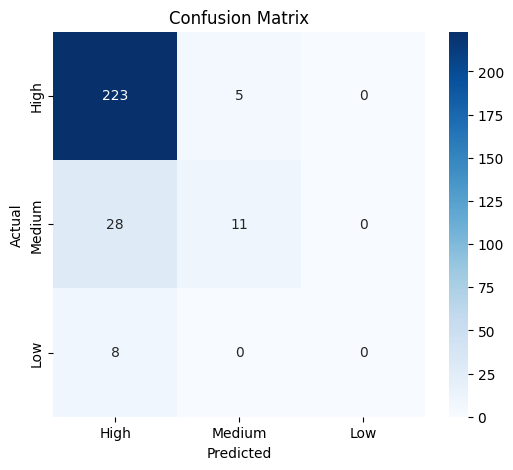

In [35]:
# Confusion matrix
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['High','Medium','Low'], yticklabels=['High','Medium','Low'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [36]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['High','Medium','Low']))



Classification Report:
              precision    recall  f1-score   support

        High       0.86      0.98      0.92       228
      Medium       0.69      0.28      0.40        39
         Low       0.00      0.00      0.00         8

    accuracy                           0.85       275
   macro avg       0.52      0.42      0.44       275
weighted avg       0.81      0.85      0.82       275



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


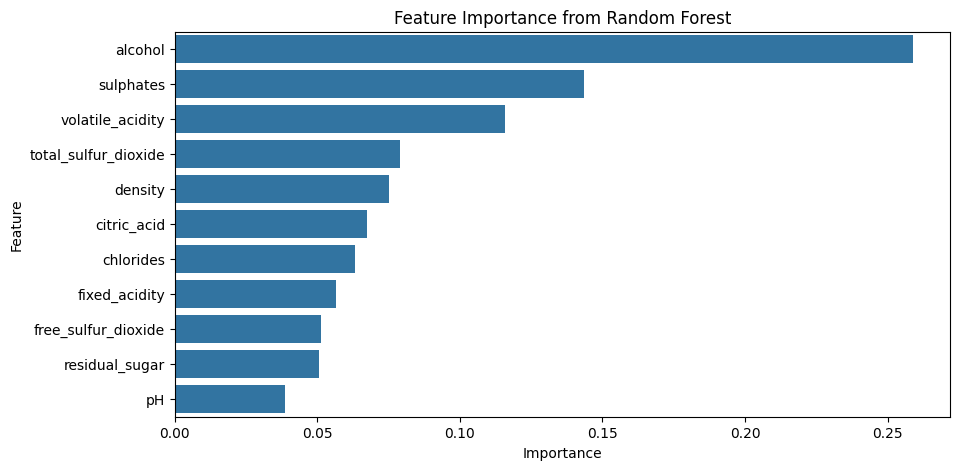

In [38]:
# ---------------------------------------------------------
# 9. Feature Importance
# ---------------------------------------------------------
# Convert SparseVector to list
importances_list = model.featureImportances.toArray().tolist()

feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances_list
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance from Random Forest")
plt.show()


In [39]:
# ---------------------------------------------------------
# 10. Stop Spark
# ---------------------------------------------------------
spark.stop()
